In [1]:
## Import modules 
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
import math 
from torchvision import transforms 
from torchvision.transforms import v2
from torchsummary import summary

from torch.utils.data import Dataset, DataLoader, default_collate

from tqdm.autonotebook import tqdm 

import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow 
from matplotlib.image import imread 

import pandas as pd 

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, jaccard_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
from scipy import ndimage
import skimage.segmentation as seg 
from skimage import color, data 
import time 
import os 
import string 


/tmp/ipykernel_14995/324680696.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Set 'Device' to GPU if Avail 

In [2]:
## Set up GPU usage in the future - all models in this notebook were trained on a Nvidia 4060 RTX 8 GB 
Device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Build DataSets for Train, Test, Val 

In [3]:
train_images = torchvision.datasets.ImageFolder('../data/processed/clin_0/train',
                                                transform = transforms.Compose([
                                                    transforms.Resize(80),
                                                    transforms.CenterCrop(78),
                                                    #transforms.ColorJitter(brightness = 0.5, hue = 0.3),
                                                    transforms.ColorJitter(contrast = .8),
                                                    transforms.ToTensor()
                                                ]))
val_images = torchvision.datasets.ImageFolder('../data/processed/clin_0/validate',
                                              transform = transforms.Compose([
                                                  transforms.Resize(80),
                                                  transforms.CenterCrop(78),
                                                  transforms.ToTensor()
                                              ]))

test_images = torchvision.datasets.ImageFolder('../data/processed/clin_0/test',
                                               transform = transforms.Compose([
                                                   transforms.Resize(80),
                                                   transforms.CenterCrop(78),
                                                   transforms.ToTensor()
                                               ]))

In [383]:
## Count instances of ABN and NO images in the training data 

abn = 0
no = 0

for n, (img, lbl) in enumerate(train_images):
    if n % 1000 == 0:
        print(n)
    if lbl == 0:
        abn += 1
    else:
        no += 1


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000


In [390]:
abn 
no 

array([25403, 16666, 19149,   859, 24123, 10746,   871,  4386,  6767,
       27913, 14140, 27059,  5684, 37810,  3894,  9149, 23220, 30719,
       36197, 13272])

In [418]:
abno_dict = {0: "Abnormal", 1: "Normal"}
abno_dict

abno_dict[train_images[1][1]]

'Abnormal'

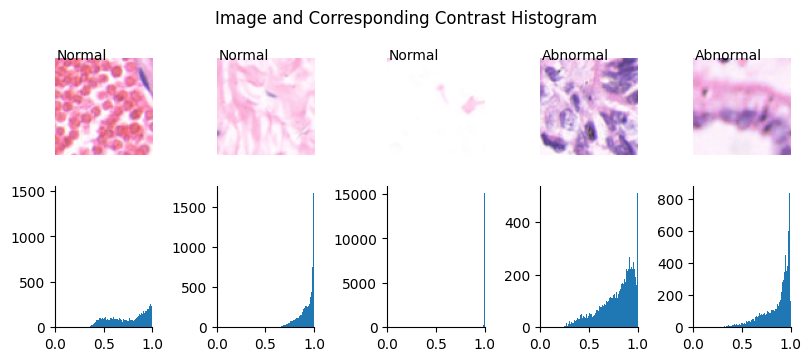

In [424]:
fig, (ax1, ax2) = plt.subplots(2,5, figsize = (8,3.5), layout = 'constrained')

fig.suptitle('Image and Corresponding Contrast Histogram')

## create a random index to select images 
imgnos = np.random.randint(1, len(train_images), 100)

for i in range(0,5):
    ax1[i].imshow(train_images[imgnos[i]][0].permute(1,2,0))
    ax1[i].text(1,1, abno_dict[train_images[imgnos[i]][1]])
    ax1[i].set_axis_off()
    ax2[i].hist(train_images[imgnos[i]][0].ravel(), bins = 256, range = [0,1])
    ax2[i].set_xlim(0,1)
    ax2[i].spines['top'].set_visible(False)
    ax2[i].spines['right'].set_visible(False)

### Display the distribution of the Data for each Image Size 

In [2]:
## Helper function to co9unt the number of files in each folder 
import os 

def count_files_in_dir(path: str) -> int:
    file_entries = [entry for entry in os.scandir(path) if entry.is_file()]

    return len(file_entries)


In [3]:
## Count files in each folder in the raw data set 
normal_80 = count_files_in_dir('../data/raw/GasHisSDB/80/Normal')
abnormal_80 = count_files_in_dir('../data/raw/GasHisSDB/80/Abnormal')
normal_120 = count_files_in_dir('../data/raw/GasHisSDB/120/Normal')
abnormal_120 = count_files_in_dir('../data/raw/GasHisSDB/120/Abnormal')
normal_160 = count_files_in_dir('../data/raw/GasHisSDB/160/Normal')
abnormal_160 = count_files_in_dir('../data/raw/GasHisSDB/160/Abnormal')

In [13]:
Image_labels = ['Normal 80', 'Abnormal 80', 'Normal 120', 'Abnormal 120', 'Normal 160', 'Abnormal 160']
Image_counts = [normal_80, abnormal_80, normal_120, abnormal_120, normal_160, abnormal_160]

dist_count = pd.DataFrame(Image_counts, Image_labels, columns = ['Image Count'])
dist_count

,Image Count
Normal 80,87500
Abnormal 80,59151
Normal 120,40460
Abnormal 120,24801
Normal 160,20160
Abnormal 160,13124


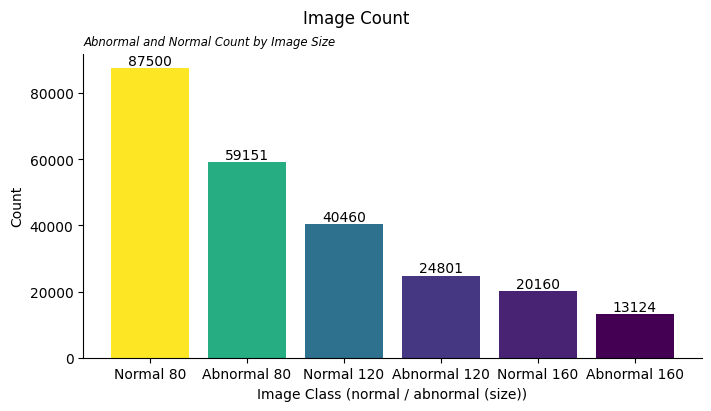

In [54]:
fig, ax = plt.subplots(figsize = (7,4), facecolor = 'white', layout = 'constrained')
fig.suptitle('Image Count')
ax.set_title('Abnormal and Normal Count by Image Size', loc='left', fontstyle='oblique', fontsize='small')

c_map = plt.get_cmap("viridis")

rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

plt_cont = ax.bar(dist_count.index, 
                  dist_count['Image Count'],
                  color = c_map(rescale(dist_count['Image Count'])))
ax.bar_label(plt_cont)
ax.set_xlabel('Image Class (normal / abnormal (size))')
ax.set_ylabel('Count')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Display the distribution of the Data for complete Data set 

In [34]:
## Get train, val test split 

clin0_train_normal = count_files_in_dir('../data/processed/clin_0/train/Normal')
clin0_train_abnormal = count_files_in_dir('../data/processed/clin_0/train/Abnormal')

clin0_val_normal = count_files_in_dir('../data/processed/clin_0/validate/Normal')
clin0_val_abnormal = count_files_in_dir('../data/processed/clin_0/validate/Abnormal')

clin0_test_normal = count_files_in_dir('../data/processed/clin_0/test/Normal')
clin0_test_abnormal = count_files_in_dir('../data/processed/clin_0/test/Abnormal')


In [40]:
## Create DF for plotting 
labs = ['Train Normal', 'Train Abnormal', 'Validate Normal', 'Validate Abnormal', 'Test Normal', 'Test Abnormal']
vals = [clin0_train_normal, clin0_train_abnormal, clin0_val_normal, clin0_val_abnormal, clin0_test_normal, clin0_test_abnormal]

clin_df = pd.DataFrame(vals, labs, columns = ['Image Count'])
clin_df

,Image Count
Train Normal,25922
Train Abnormal,16989
Validate Normal,9258
Validate Abnormal,6068
Test Normal,1852
Test Abnormal,1216


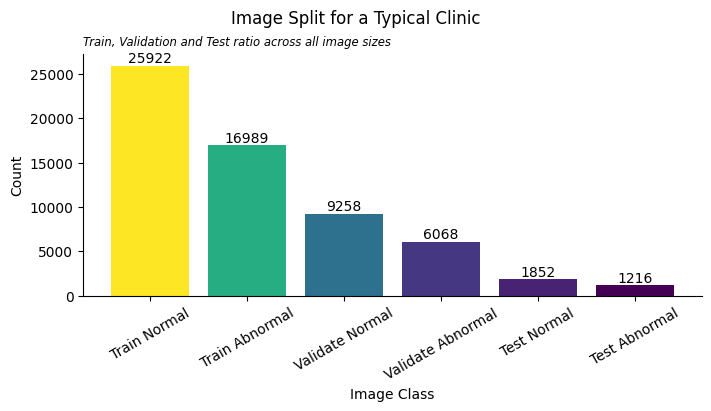

In [53]:
## Data Distribution for each clinic 

fig, ax = plt.subplots(figsize=(7,4), facecolor='white', layout='constrained')
fig.suptitle('Image Split for a Typical Clinic')
ax.set_title('Train, Validation and Test ratio across all image sizes', loc='left', fontstyle='oblique', fontsize='small')

c_map = plt.get_cmap("viridis")

rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

plt_cont = ax.bar(clin_df.index, 
                  clin_df['Image Count'],
                  color = c_map(rescale(dist_count['Image Count'])))
ax.bar_label(plt_cont)
ax.set_xlabel('Image Class')
ax.set_ylabel('Count')
## set ticklabels on an angle for readability
for tick in ax.get_xticklabels():
    tick.set_rotation(30)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Build DataLoaders 
Set the batch size to the number of workers and the capacity of GPU (RAM). 

In [4]:
## Define the Cutmix function 
cutmix = v2.CutMix(num_classes = 2)

## Define the mixup function 
mixup = v2.MixUp(num_classes = 2)

## Define the collate function for mixup implementation 
def collate_fn(batch):
    return cutmix(*default_collate(batch))




In [5]:
B = 128
## Number of workers is selected based on the number of cores the cpu has - generally select one less than is available to maximise the use of the GPU
train_loader = DataLoader(train_images, batch_size = B,num_workers = 5,pin_memory = True, shuffle = True)# collate_fn = collate_fn)
val_loader = DataLoader(val_images, batch_size = B, num_workers = 5, pin_memory = True)
test_loader = DataLoader(test_images, batch_size = B, num_workers = 5, pin_memory = True)

### Inspect the Data Images

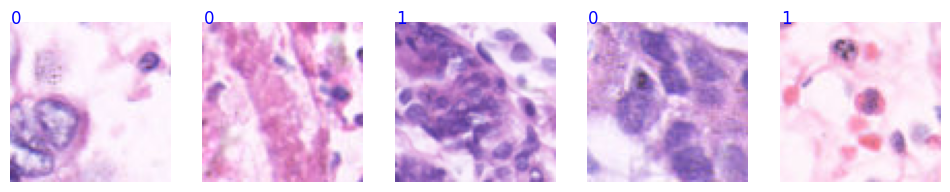

In [38]:
## Inspect random images from the validation data set 
fig, ax = plt.subplots(1,5, figsize = (12, 5))
val_len = len(val_images)
rand_imgs = np.random.randint(1, val_len, 5)
count = 0
# fig.suptitle('Random Images from Validation Data Set')
for i in rand_imgs:
    x, y = val_images[i]
    ax[count].imshow(x.numpy().transpose(1,2,0))
    ax[count].text(0.0, 0.5, str(round(y,2)), dict(size = 12, color = 'blue'))
    ax[count].set_axis_off() ## turn off the axis for the images  
    count += 1

## Get Model - RESNET 

In [19]:
## Get resnet model 
resnet18_pretrain = torchvision.models.resnet18(weights = 'ResNet18_Weights.DEFAULT') 

In [20]:
## Freeze all the parameters 
for param in resnet18_pretrain.parameters():
    param.requires_grad = False             

### Alter the final Layer for a Binary Problem 

In [21]:
## Alter the final layer for a binary problem
## The drop out layer was inserted to help with overfitting 
resnet18_pretrain.fc = nn.Sequential(
    nn.Linear(in_features = 512, out_features = 256, bias = True),
    nn.Dropout(p = 0.5),
    nn.Linear(in_features = 256, out_features = 2, bias = True)
)

In [22]:
summary(resnet18_pretrain.to(Device), (3,60,60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           9,408
       BatchNorm2d-2           [-1, 64, 30, 30]             128
              ReLU-3           [-1, 64, 30, 30]               0
         MaxPool2d-4           [-1, 64, 15, 15]               0
            Conv2d-5           [-1, 64, 15, 15]          36,864
       BatchNorm2d-6           [-1, 64, 15, 15]             128
              ReLU-7           [-1, 64, 15, 15]               0
            Conv2d-8           [-1, 64, 15, 15]          36,864
       BatchNorm2d-9           [-1, 64, 15, 15]             128
             ReLU-10           [-1, 64, 15, 15]               0
       BasicBlock-11           [-1, 64, 15, 15]               0
           Conv2d-12           [-1, 64, 15, 15]          36,864
      BatchNorm2d-13           [-1, 64, 15, 15]             128
             ReLU-14           [-1, 64,

### Normalise Input in model 

In [9]:
## Do the normalization outside of the Data prep as it is specific to the model 
class NormalizeInput(nn.Module):
    def __init__(self, baseModel):
        """
        baseModel: the original ResNet model that needs to have it's inputs pre-processed
        """
        super(NormalizeInput, self).__init__()
        self.baseModel = baseModel #The model that we want to use, but need’s its input normalized first. 
        #The mean and standard deviation used for ImageNet normalization. We just have to accept these “magic” numbers that everyone uses.  
        self.mean = nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1), requires_grad=False) #Notice requires_grad=False, we don't want these to change during training!
        self.std = nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1), requires_grad=False)
    
    def forward(self, input):
        #Normalize the input, then feed it into the model we want to use
        input = (input-self.mean)/self.std
        return self.baseModel(input)

In [24]:
resnet18_pretrain_N = NormalizeInput(resnet18_pretrain)

### Inspect the Model 

In [25]:
## Normalise the weights in the model and inspect the structure of the model - checking the fc 
summary(resnet18_pretrain_N.to(Device), (3,60,60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           9,408
       BatchNorm2d-2           [-1, 64, 30, 30]             128
              ReLU-3           [-1, 64, 30, 30]               0
         MaxPool2d-4           [-1, 64, 15, 15]               0
            Conv2d-5           [-1, 64, 15, 15]          36,864
       BatchNorm2d-6           [-1, 64, 15, 15]             128
              ReLU-7           [-1, 64, 15, 15]               0
            Conv2d-8           [-1, 64, 15, 15]          36,864
       BatchNorm2d-9           [-1, 64, 15, 15]             128
             ReLU-10           [-1, 64, 15, 15]               0
       BasicBlock-11           [-1, 64, 15, 15]               0
           Conv2d-12           [-1, 64, 15, 15]          36,864
      BatchNorm2d-13           [-1, 64, 15, 15]             128
             ReLU-14           [-1, 64,

## Get Model - VGG-16 

In [69]:
vgg16_pretrain = torchvision.models.vgg16_bn(weights = 'DEFAULT')

### Freeze Params 

In [70]:
for param in vgg16_pretrain.parameters():
    param.requires_grad = False 

### Alter the FC Layer 

In [72]:
#vgg_pretrain.classifier = nn.Sequential(
#    nn.Linear(in_features = 25088, out_features = 4096, bias = True),
#    nn.ReLU(inplace = True),
#    nn.Dropout(p = 0.5, inplace = False),
#    nn.Linear(in_features = 4096, out_features = 2048, bias = True),
#    nn.ReLU(inplace = True),
#    nn.Dropout(p = 0.5, inplace = False),
#    nn.Linear(in_features = 2048, out_features = 2, bias = True)

vgg16_pretrain.classifier = nn.Sequential(
    nn.Linear(in_features = 25088, out_features = 4096, bias = True),
    nn.Dropout(p = 0.5),
    nn.Linear(in_features = 4096, out_features = 2, bias = True)
)

### Inspect the Model 

In [73]:
summary(vgg16_pretrain.to(Device), (3, 80, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 60, 60]           1,792
       BatchNorm2d-2           [-1, 64, 60, 60]             128
              ReLU-3           [-1, 64, 60, 60]               0
            Conv2d-4           [-1, 64, 60, 60]          36,928
       BatchNorm2d-5           [-1, 64, 60, 60]             128
              ReLU-6           [-1, 64, 60, 60]               0
         MaxPool2d-7           [-1, 64, 30, 30]               0
            Conv2d-8          [-1, 128, 30, 30]          73,856
       BatchNorm2d-9          [-1, 128, 30, 30]             256
             ReLU-10          [-1, 128, 30, 30]               0
           Conv2d-11          [-1, 128, 30, 30]         147,584
      BatchNorm2d-12          [-1, 128, 30, 30]             256
             ReLU-13          [-1, 128, 30, 30]               0
        MaxPool2d-14          [-1, 128,

### Normalise The Model 

In [74]:
vgg16_pretrain_N = NormalizeInput(vgg16_pretrain)

## Get Model VGG-19 

In [83]:
## Import the model 

vgg19_pretrained = torchvision.models.vgg19(weights = 'DEFAULT')

In [84]:
## Freeze all layers 

for param in vgg19_pretrained.parameters():
    param.requires_grad = False 

In [86]:
## Alter the FC layer 

vgg19_pretrained.classifier = nn.Sequential(
    nn.Linear(in_features = 25088, out_features = 4096, bias = True),
    nn.Dropout(p = 0.5),
    nn.Linear(in_features = 4096, out_features = 2, bias = True)
)

In [88]:
vgg19_pretrained_N = NormalizeInput(vgg19_pretrained)

In [89]:
## Inspect the model 

summary(vgg19_pretrained.to(Device), (3,80,80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]           1,792
              ReLU-2           [-1, 64, 80, 80]               0
            Conv2d-3           [-1, 64, 80, 80]          36,928
              ReLU-4           [-1, 64, 80, 80]               0
         MaxPool2d-5           [-1, 64, 40, 40]               0
            Conv2d-6          [-1, 128, 40, 40]          73,856
              ReLU-7          [-1, 128, 40, 40]               0
            Conv2d-8          [-1, 128, 40, 40]         147,584
              ReLU-9          [-1, 128, 40, 40]               0
        MaxPool2d-10          [-1, 128, 20, 20]               0
           Conv2d-11          [-1, 256, 20, 20]         295,168
             ReLU-12          [-1, 256, 20, 20]               0
           Conv2d-13          [-1, 256, 20, 20]         590,080
             ReLU-14          [-1, 256,

## Get Model - MNASTNET1_3 

In [179]:
mnasnet = torchvision.models.mnasnet1_3(weights = 'IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/mnasnet1_3-a4c69d6f.pth" to /home/james/.cache/torch/hub/checkpoints/mnasnet1_3-a4c69d6f.pth
100%|██████████| 24.2M/24.2M [00:12<00:00, 2.09MB/s]


In [180]:
## Freeze the params 

for param in mnasnet.parameters():
    param.requires_grad = False 

In [183]:
## Alter the fc layer for a binary classification problem 

mnasnet.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features = 1280, out_features = 2)
)

In [186]:
## Normalise the input for the model 

NormalizeInput(mnasnet)

NormalizeInput(
  (baseModel): MNASNet(
    (layers): Sequential(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
      (4): BatchNorm2d(40, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (7): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
      (8): Sequential(
        (0): _InvertedResidual(
          (layers): Sequential(
            (0): Conv2d(24, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(72, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
 

In [187]:
summary(mnasnet.to(Device), (3,60,60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 40, 30, 30]           1,080
       BatchNorm2d-2           [-1, 40, 30, 30]              80
              ReLU-3           [-1, 40, 30, 30]               0
            Conv2d-4           [-1, 40, 30, 30]             360
       BatchNorm2d-5           [-1, 40, 30, 30]              80
              ReLU-6           [-1, 40, 30, 30]               0
            Conv2d-7           [-1, 24, 30, 30]             960
       BatchNorm2d-8           [-1, 24, 30, 30]              48
            Conv2d-9           [-1, 72, 30, 30]           1,728
      BatchNorm2d-10           [-1, 72, 30, 30]             144
             ReLU-11           [-1, 72, 30, 30]               0
           Conv2d-12           [-1, 72, 15, 15]             648
      BatchNorm2d-13           [-1, 72, 15, 15]             144
             ReLU-14           [-1, 72,

## Get RESNEXT-101 

In [6]:
## Import model 

resnext_101 = torchvision.models.resnext101_64x4d(weights = 'DEFAULT')

In [7]:
## Freeze Parameters 

for param in resnext_101.parameters():
    param.requires_grad = False 

In [8]:
## Alter the FC layer 

resnext_101.fc = nn.Linear(in_features = 2048, out_features = 2, bias = True)

In [10]:
## Normalise the model with weights - Standard weights from Imagenet in Pytorch models 

NormalizeInput(resnext_101)


NormalizeInput(
  (baseModel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsampl

In [11]:
## Inspect model  

summary(resnext_101.to(Device), (3,80,80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 40, 40]           9,408
       BatchNorm2d-2           [-1, 64, 40, 40]             128
              ReLU-3           [-1, 64, 40, 40]               0
         MaxPool2d-4           [-1, 64, 20, 20]               0
            Conv2d-5          [-1, 256, 20, 20]          16,384
       BatchNorm2d-6          [-1, 256, 20, 20]             512
              ReLU-7          [-1, 256, 20, 20]               0
            Conv2d-8          [-1, 256, 20, 20]           9,216
       BatchNorm2d-9          [-1, 256, 20, 20]             512
             ReLU-10          [-1, 256, 20, 20]               0
           Conv2d-11          [-1, 256, 20, 20]          65,536
      BatchNorm2d-12          [-1, 256, 20, 20]             512
           Conv2d-13          [-1, 256, 20, 20]          16,384
      BatchNorm2d-14          [-1, 256,

## Get Wide RESNET 101 

In [25]:
## Download model with default weights 

resnet_101_wide = torchvision.models.wide_resnet101_2(weights = 'DEFAULT')

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-d733dc28.pth" to /home/james/.cache/torch/hub/checkpoints/wide_resnet101_2-d733dc28.pth
100%|██████████| 485M/485M [02:33<00:00, 3.30MB/s] 


In [26]:
## Freeze Parameters 

for param in resnet_101_wide.parameters():
    param.requires_grad = False 

In [29]:
## Alter the classifier 

resnet_101_wide.fc = nn.Linear(in_features = 2048, out_features = 2, bias = True)

In [30]:
## Normalise the model 

## Normalise the model with weights - Standard weights from Imagenet in Pytorch models 

NormalizeInput(resnet_101_wide)

NormalizeInput(
  (baseModel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequent

In [31]:
## Inspect model  

summary(resnet_101_wide.to(Device), (3,80,80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 40, 40]           9,408
       BatchNorm2d-2           [-1, 64, 40, 40]             128
              ReLU-3           [-1, 64, 40, 40]               0
         MaxPool2d-4           [-1, 64, 20, 20]               0
            Conv2d-5          [-1, 128, 20, 20]           8,192
       BatchNorm2d-6          [-1, 128, 20, 20]             256
              ReLU-7          [-1, 128, 20, 20]               0
            Conv2d-8          [-1, 128, 20, 20]         147,456
       BatchNorm2d-9          [-1, 128, 20, 20]             256
             ReLU-10          [-1, 128, 20, 20]               0
           Conv2d-11          [-1, 256, 20, 20]          32,768
      BatchNorm2d-12          [-1, 256, 20, 20]             512
           Conv2d-13          [-1, 256, 20, 20]          16,384
      BatchNorm2d-14          [-1, 256,

## Build Model from Scratch Based on RESNET

This will be a basic model from scratch based on RESNET Modules specifically trying to normalise the over-training by implementing dropout in the basic blocks at much lower levels than the traditional 0.5 that is used in the fully connected layer. The Drop-out was implemented after the activation function IAW the research from the following paper http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf 

In [6]:
## Creater a class for the basic building block 
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, drop_out = 0.2):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.drop_out = nn.Dropout(drop_out)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.drop_out(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        out = self.drop_out(out)
        return out

## Create a class for the overall model 
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        '''
        num_classes = int || default = 10 adjust accordingly 
        dropout is applied to the in the basic block after the activation function (Relu) based on research circa 2021. It was found that applyign after batch normalisation wasn't as effective as applying after the activation function. 
        '''
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [9]:
## Instantiate an instance of the model 
resnet18_w_dropout = ResNet18(2)

In [10]:
## Normalise the model 

resnet18_w_dropout_N = NormalizeInput(resnet18_w_dropout)

In [11]:
## Inspect the model 
summary(resnet18_w_dropout_N.to(Device), (3, 80, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]           1,728
       BatchNorm2d-2           [-1, 64, 80, 80]             128
              ReLU-3           [-1, 64, 80, 80]               0
         MaxPool2d-4           [-1, 64, 40, 40]               0
            Conv2d-5           [-1, 64, 40, 40]          36,864
       BatchNorm2d-6           [-1, 64, 40, 40]             128
              ReLU-7           [-1, 64, 40, 40]               0
           Dropout-8           [-1, 64, 40, 40]               0
            Conv2d-9           [-1, 64, 40, 40]          36,864
      BatchNorm2d-10           [-1, 64, 40, 40]             128
             ReLU-11           [-1, 64, 40, 40]               0
          Dropout-12           [-1, 64, 40, 40]               0
       BasicBlock-13           [-1, 64, 40, 40]               0
           Conv2d-14           [-1, 64,

## Create Training Loop and helpers 

In [16]:
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs. 
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary. 
    desc -- a description to use for the progress bar.     
    """
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
            #print(y_true)
            #print(y_pred)
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

In [17]:
def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return obj

In [18]:
def train_network(model, loss_func, train_loader, val_loader=None, test_loader=None,score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, 
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evaluate the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute location to perform training
    lr_schedule -- the learning rate schedule used to alter \eta as the model trains. If this is not None than the user must also provide the optimizer to use. 
    optimizer -- the method used to alter the gradients for learning. 
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        if test_loader is not None:
            to_track.append("test "+ eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

        
    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())
        del_opt = True
    else:
        del_opt = False

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        
      
        if val_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, val_loader, loss_func, device, results, score_funcs, prefix="val", desc="Validating")
                
        #In PyTorch, the convention is to update the learning rate after every epoch
        if lr_schedule is not None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(results["val loss"][-1])
            else:
                lr_schedule.step()
                
        if test_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")        
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)
    if del_opt:
        del optimizer

    return pd.DataFrame.from_dict(results)

## Set up Model for Running 

In [ ]:
## Set the model 

Model = resnet_101_wide
Check_point_file = 'client_models_checkpoint/resnet_101_wide.pt'
# resnet18_pretrain_N
# vgg16_pretrain_N
# vgg19_pretrained_N
# resnet18_w_dropout_N
# masnect 
# resnext_101 
# resnet_101_wide 
## Set the optimiser for the binary classification 
Optim = torch.optim.Adam(params = Model.parameters())
## Set up a learning rate scheduler that will give us the best result based on loss decay
Scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(Optim, mode='min', factor=0.2, patience=4)
## Set the number of epochs for training 
Epochs = 30
## Set the loss function 
loss = nn.CrossEntropyLoss()
## Score Functions 
Score_Funcs = {'Precision': precision_score, 'Recall': recall_score, 'F1': f1_score, 'ROC': roc_auc_score, 'Jaccard Score': jaccard_score, 'Confusion Matrix': confusion_matrix}

## Train Model 

In [35]:

results = train_network(model = Model, 
                               loss_func = loss,
                               train_loader = train_loader,
                                val_loader = val_loader,
                                test_loader = test_loader,
                                epochs = Epochs,
                                optimizer = Optim,
                                lr_schedule = Scheduler,
                                device = Device,
                                score_funcs = Score_Funcs,
                                checkpoint_file = Check_point_file
                                ) 
                                 

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validating:   0%|          | 0/120 [00:00<?, ?it/s]

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

## Check Model Weights and Bias 

Below is an example of how to access the different elements of the pre-trained model. This is also an example of how to initialise the model and load the weights and bias into the model for use in the FedAvg context. 

In [212]:
## How to load the model from the saved .pt file 
resnet_drop_out_model = ResNet18(2) ## Initialise the new model from the class above 
checkpoint_dict = torch.load("client_models_checkpoint/resnet_dropout/resnet_w_dropout.pt", map_location = Device) ## load the model params into a 'checkpoint' 
resnet_drop_out_model.load_state_dict(checkpoint_dict['model_state_dict'])

/tmp/ipykernel_7509/930482838.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_dict = torch.load("client_models_checkpoint/resnet_dropout/resnet_w_dropout.pt",

<All keys matched successfully>

In [219]:
pd.DataFrame(checkpoint_dict['results']).to_csv('results/resnet_w_dropout_60_no_augmentation.csv')

In [142]:
## Check the params for each of the params 
for names, param in resnet_drop_out_model.named_parameters():
    print(names, param)

conv1.weight Parameter containing:
tensor([[[[-0.1732,  0.0293,  0.0401],
          [ 0.0368,  0.2779,  0.0256],
          [-0.0877,  0.0215, -0.2362]],

         [[-0.0962,  0.0465, -0.2120],
          [-0.1239, -0.1423,  0.1414],
          [ 0.0016, -0.1017,  0.0988]],

         [[ 0.1044, -0.1358, -0.1359],
          [ 0.2054,  0.2727,  0.0944],
          [ 0.0175,  0.0388, -0.1402]]],


        [[[-0.1151, -0.1927,  0.0526],
          [-0.0825, -0.2253, -0.1692],
          [-0.1331, -0.2428, -0.0926]],

         [[-0.0730,  0.1989, -0.0245],
          [-0.0131,  0.1941,  0.1096],
          [ 0.0831,  0.1242,  0.0804]],

         [[ 0.2367, -0.0801,  0.0900],
          [ 0.0282,  0.1332, -0.0818],
          [-0.0230,  0.0289,  0.0713]]],


        [[[-0.0030,  0.2116,  0.0512],
          [-0.0888, -0.1112,  0.0192],
          [-0.0203,  0.2171, -0.0461]],

         [[-0.1516, -0.1997, -0.0296],
          [-0.1119, -0.1624, -0.1330],
          [-0.1109, -0.1205, -0.1424]],

         

## Check the Results 

In [36]:
results.tail(10)

,epoch,total time,train loss,val loss,test loss,train Precision,val Precision,test Precision,train Recall,val Recall,...,test F1,train ROC,val ROC,test ROC,train Jaccard Score,val Jaccard Score,test Jaccard Score,train Confusion Matrix,val Confusion Matrix,test Confusion Matrix
20,20,1235.845260,0.360361,0.364392,0.357176,0.859038,0.853098,0.861797,0.881606,0.898250,...,0.873502,0.830438,0.831129,0.834623,0.770187,0.777923,0.775414,"[[13239, 3750], [3069, 22853]]","[[4636, 1432], [942, 8316]]","[[953, 263], [212, 1640]]"
21,21,1271.952922,0.356491,0.372193,0.361728,0.859123,0.863636,0.875888,0.884577,0.878375,...,0.870416,0.831629,0.833387,0.839167,0.772522,0.771391,0.770563,"[[13229, 3760], [2992, 22930]]","[[4784, 1284], [1126, 8132]]","[[989, 227], [250, 1602]]"
22,22,1308.344381,0.359152,0.366426,0.359937,0.860093,0.849846,0.862724,0.882224,0.895010,...,0.872397,0.831629,0.826872,0.834237,0.771507,0.772804,0.773674,"[[13269, 3720], [3053, 22869]]","[[4604, 1464], [972, 8286]]","[[956, 260], [218, 1634]]"
23,23,1344.915429,0.357957,0.364204,0.359713,0.862025,0.852348,0.867733,0.878752,0.894146,...,0.873088,0.832071,0.828912,0.837281,0.770394,0.774224,0.774762,"[[13343, 3646], [3143, 22779]]","[[4634, 1434], [980, 8278]]","[[968, 248], [225, 1627]]"
24,24,1381.396399,0.357677,0.364036,0.355021,0.860372,0.853699,0.868126,0.882609,0.891229,...,0.873020,0.832028,0.829102,0.837422,0.772026,0.773145,0.774655,"[[13276, 3713], [3043, 22879]]","[[4654, 1414], [1007, 8251]]","[[969, 247], [226, 1626]]"
25,25,1417.677995,0.360008,0.364636,0.359557,0.859414,0.861707,0.866235,0.881992,0.885720,...,0.866703,0.830925,0.834423,0.831612,0.770784,0.775487,0.764762,"[[13249, 3740], [3059, 22863]]","[[4752, 1316], [1058, 8200]]","[[968, 248], [246, 1606]]"
26,26,1454.300690,0.357129,0.362756,0.356546,0.860322,0.858558,0.870620,0.881529,0.889069,...,0.871325,0.831576,0.832801,0.837331,0.771160,0.775485,0.771989,"[[13279, 3710], [3071, 22851]]","[[4712, 1356], [1027, 8231]]","[[976, 240], [237, 1615]]"
27,27,1490.549559,0.356025,0.366952,0.362609,0.860588,0.846420,0.856771,0.881105,0.900086,...,0.872216,0.831658,0.825455,0.831039,0.771049,0.773723,0.773390,"[[13289, 3700], [3082, 22840]]","[[4556, 1512], [925, 8333]]","[[941, 275], [207, 1645]]"
28,28,1526.306360,0.359295,0.364513,0.364650,0.860654,0.857039,0.867914,0.883497,0.890365,...,0.872112,0.832619,0.831883,0.836612,0.772933,0.775228,0.773225,"[[13281, 3708], [3020, 22902]]","[[4693, 1375], [1015, 8243]]","[[969, 247], [229, 1623]]"
29,29,1562.356601,0.360439,0.366987,0.359631,0.858452,0.856532,0.868844,0.882031,0.887341,...,0.872581,0.830061,0.830289,0.837435,0.770039,0.772522,0.773963,"[[13219, 3770], [3058, 22864]]","[[4692, 1376], [1043, 8215]]","[[971, 245], [229, 1623]]"


In [37]:
print(results['test F1'].max().round(3))
print(results['test loss'].min().round(3))

0.875
0.355


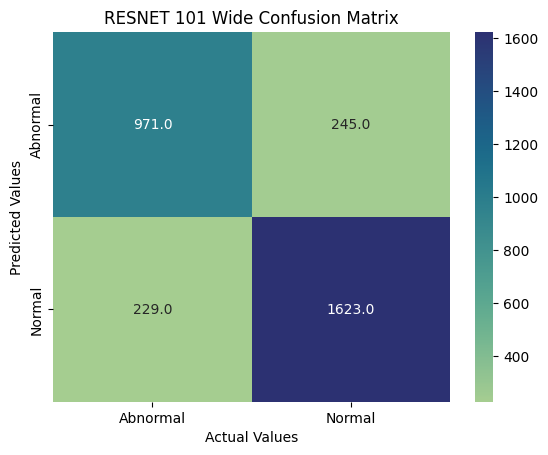

In [39]:
## Inspect how many times it mis-classifies 
cm = results['test Confusion Matrix'].tail(1)
cm = cm.reset_index(drop=True)
labels = ['Abnormal', 'Normal']

#cm = ConfusionMatrixDisplay(cm.iloc[0], display_labels=labels)


fig, ax = plt.subplots()
ax = sns.heatmap(cm[0], annot=True, xticklabels=labels, yticklabels=labels, fmt = '.1f', cmap = 'crest')
ax.set_title('RESNET 101 Wide Confusion Matrix')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')

fig.savefig('../report_2/images/resnet_101_wide_cm.png')

### Store the Results as a CSV 

In [40]:
results.to_csv('results/resnet_101_wide.csv')

##notebooks/results/resnet_w_dropout.csv


In [28]:
baseModel = pd.read_csv('results/resnet_w_dropout.csv')
# results/resnet18_pretrain
# results/resnet_w_dropout.csv 
# results/vgg16_pretrained.csv 
# results/vgg19_pretrained.csv

In [29]:
print(baseModel['test F1'].max().round(3))
print(baseModel['test loss'].min().round(3))

0.968
0.103


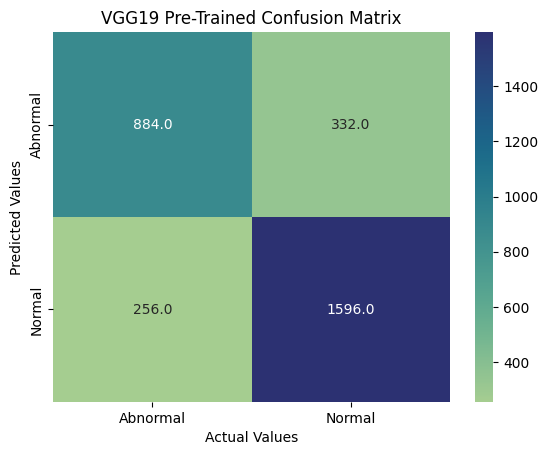

In [17]:
import re 

cm = vgg19pt['test Confusion Matrix'].tail(1)
cm = cm.reset_index(drop=True)
labels = ['Abnormal', 'Normal']
fig, ax = plt.subplots() 

cm[0] = [int(s) for s in re.findall(r'\b\d+\b', cm[0])]

a = [cm[0][0], cm[0][1]]
b = [cm[0][2], cm[0][3]]
tup1 = tuple(a) 
tup2 = tuple(b) 
cm[0] = ((tup1,) + (tup2,))
cm[0]

x = sns.heatmap(cm[0], annot=True, xticklabels=labels, yticklabels=labels, fmt = '.1f', cmap = 'crest')
ax.set_title('VGG19 Pre-Trained Confusion Matrix')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')

fig.savefig('../report_2/images/vgg19_pretrained_cm.png')

In [ ]:

ax = sns.heatmap(cm[0], annot=True, xticklabels=labels, yticklabels=labels, fmt = '.1f', cmap = 'crest')
ax.set_title('RESNET with Dropout Confusion Matrix')


fig.savefig('../report_2/images/resnet_pretrained_cm.png')

In [194]:
## Inspect Colmun names for plotting 
results.columns

Index(['total time', 'train loss', 'val loss', 'test loss', 'train Precision',
       'val Precision', 'test Precision', 'train Recall', 'val Recall',
       'test Recall', 'train F1', 'val F1', 'test F1', 'train ROC', 'val ROC',
       'test ROC', 'train Jaccard Score', 'val Jaccard Score',
       'test Jaccard Score', 'train Confusion Matrix', 'val Confusion Matrix',
       'test Confusion Matrix'],
      dtype='object')

## Inspect Results 
Plot figures checking both accuracy and loss rate 

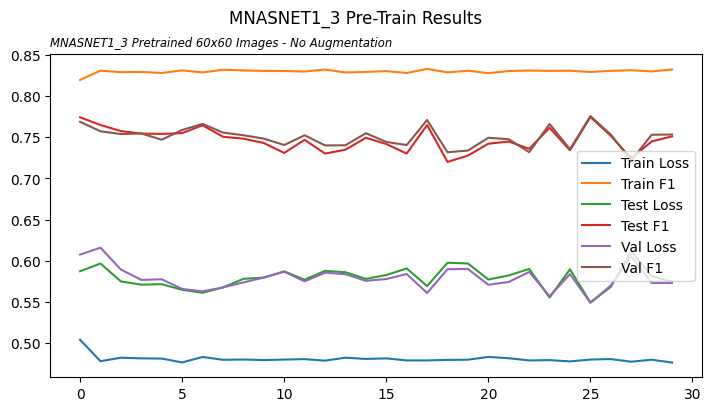

In [195]:
fig, ax = plt.subplots(figsize=(7,4), facecolor='white', layout='constrained')
fig.suptitle('MNASNET1_3 Pre-Train Results')
ax.set_title('MNASNET1_3 Pretrained 60x60 Images - No Augmentation', loc='left', fontstyle='oblique', fontsize='small')
ax.plot(df['train loss'], label = 'Train Loss')
ax.plot(df['train F1'], label = 'Train F1')
ax.plot(df['test loss'], label = 'Test Loss')
ax.plot(df['test F1'], label = 'Test F1')
ax.plot(df['val loss'], label = 'Val Loss')
ax.plot(df['val F1'], label = 'Val F1')
leg = ax.legend()

In [196]:
fig.savefig('../report_2/images/mnasnet_pre-trained_60')

### Experiment Results 
Two experiments were run initially. One without pretrained weights and one with pre-trained weights. The weights for the 'warm start' were taken from the pytorch documentation specific to the RESNET-18 model on the Imagenet data set. 
The results below highlight the strength of the warm start results and effective transfer learning can be. 
Image sizes were altered from 60 - 90 - 120 - 160 as part of the experimentation. 

Highlighted below is some of the weaknesses in the Data in that the bulk of the images are 60x60. As the images are rescaled to upwards the detail is lost for the model to learn from. 

<Axes: xlabel='epoch', ylabel='test Accuracy'>

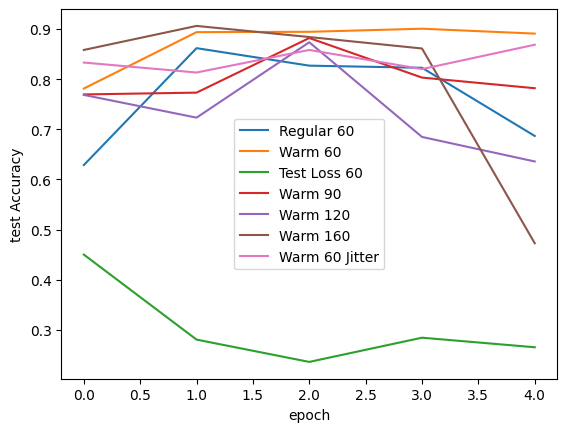

In [92]:
## Plot results 
sns.lineplot(x = 'epoch', y = 'test Accuracy', data = normal_results, label='Regular 60')
sns.lineplot(x = 'epoch', y = 'test Accuracy', data = warm_results, label = 'Warm 60')
sns.lineplot(x = 'epoch', y = 'test loss', data = warm_results, label = 'Test Loss 60')
sns.lineplot(x = 'epoch', y = 'test Accuracy', data = warm_results_90, label = 'Warm 90')
sns.lineplot(x = 'epoch', y = 'test Accuracy', data = warm_results_120, label = 'Warm 120')
sns.lineplot(x = 'epoch', y = 'test Accuracy', data = warm_results_160, label = 'Warm 160')
sns.lineplot(x = 'epoch', y = 'test Accuracy', data = warm_results_60_jitter, label = 'Warm 60 Jitter')


## Plot Model Comparison 

In [7]:
vgg16_results = pd.read_csv('results/vgg16_pretrained.csv')
vgg19_results = pd.read_csv('results/vgg19_pretrained.csv')
resnet18_pretrain = pd.read_csv('results/resnet_pretrained.csv')
resnet_dropout = pd.read_csv('results/resnet_w_dropout.csv')

0     0.830853
1     0.774793
2     0.703070
3     0.812240
4     0.675490
5     0.769549
6     0.822339
7     0.840476
8     0.831173
9     0.837515
10    0.822247
11    0.835911
12    0.829109
13    0.838796
14    0.840609
15    0.841903
16    0.831411
17    0.840124
18    0.842958
19    0.843533
20    0.842482
21    0.838703
22    0.842523
23    0.842803
24    0.840451
25    0.841290
26    0.843104
27    0.842796
28    0.843781
29    0.843189
Name: val F1, dtype: float64

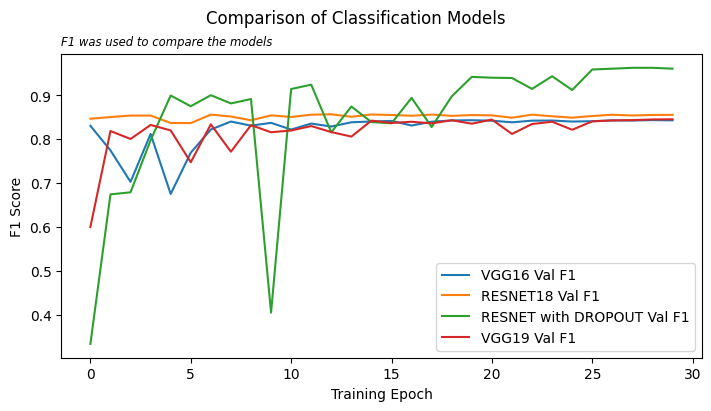

In [9]:
### Create visualisations for comparison of classification models 

fig, ax = plt.subplots(figsize=(7,4), facecolor='white', layout='constrained')
fig.suptitle('Comparison of Classification Models')
ax.set_title('F1 was used to compare the models', loc='left', fontstyle='oblique', fontsize='small')

#ax.plot(mnasnet_pretrain['val F1'], label = 'MNASNET Val Accuracy')

ax.plot(vgg16_results['val F1'], label = 'VGG16 Val F1')
ax.plot(resnet18_pretrain['val F1'], label = 'RESNET18 Val F1')
ax.plot(resnet_dropout['val F1'], label = 'RESNET with DROPOUT Val F1')
ax.plot(vgg19_results['val F1'], label = 'VGG19 Val F1')
ax.set_ylabel('F1 Score')
ax.set_xlabel('Training Epoch')


leg = ax.legend()

In [228]:
fig.savefig('../report_2/images/classification_comparison')

In [ ]:
Index(['total time', 'train loss', 'val loss', 'test loss', 'train Precision',
       'val Precision', 'test Precision', 'train Recall', 'val Recall',
       'test Recall', 'train F1', 'val F1', 'test F1', 'train ROC', 'val ROC',
       'test ROC', 'train Jaccard Score', 'val Jaccard Score',
       'test Jaccard Score', 'train Confusion Matrix', 'val Confusion Matrix',
       'test Confusion Matrix'],
      dtype='object')